In [65]:
import pandas as pd
import keras
import utils
from keras.models import model_from_yaml
import matplotlib.pyplot as plt
from pylab import rcParams
rcParams['figure.figsize'] = 10, 20
import numpy as np
from pandas_summary import DataFrameSummary

%matplotlib inline

In [166]:
# load data
data_dir = r'./data'
trn = pd.read_csv('{}/air_visit_data.csv'.format(data_dir))
data = {
    'tra': pd.read_csv('{}/air_visit_data.csv'.format(data_dir)),
    # 'tes': pd.read_csv('{}/sample_submission.csv'.format(data_dir)),
    'as': pd.read_csv('{}/air_store_info.csv'.format(data_dir)),
    'hs': pd.read_csv('{}/hpg_store_info.csv'.format(data_dir)),
    'ar': pd.read_csv('{}/air_reserve.csv'.format(data_dir)),
    'hr': pd.read_csv('{}/hpg_reserve.csv'.format(data_dir)),
    'id': pd.read_csv('{}/store_id_relation.csv'.format(data_dir)),
    'hol': pd.read_csv('{}/date_info.csv'.format(data_dir))
}
# Prepare store info
data['as'] = data['as'].rename({'latitude': 'air_latitude', 'longitude': 'air_longitude'}, axis='columns')
data['hs'] = data['hs'].rename({'latitude': 'hpg_latitude', 'longitude': 'hpg_longitude'}, axis='columns')
stores = pd.merge(data['as'],  data['id'], how='left' )
stores = pd.merge(stores,  data['hs'], how='left')
# only use air_store_id
stores = stores.drop(columns=['hpg_store_id'])

# Prepare static of stores
key = 'air_store_id'
agg = data['tra'].groupby(key).agg([np.min, np.max, np.mean, np.std]).rename(
  columns={
    'amin': 'min_{}'.format('visits'),
    'amax': 'max_{}'.format('visits'),
    'mean': 'mean_{}'.format('visits'),
    'std': 'std_{}'.format('visits')
})
agg.reset_index(inplace=True)
agg.columns = agg.columns.droplevel()
agg = agg.reset_index()
agg.rename(
    {
        '': key,
}, axis='columns', inplace=True)

#merge store statics into store info
stores = pd.merge(stores, agg)

In [4]:
stores.to_csv('./insight/store_stas.csv')

In [66]:
with open('result/model_bn.yml') as file_obj:
    model_yml = file_obj.read()

In [67]:
model = model_from_yaml(model_yml)

In [68]:
model.load_weights('result/model_bn_yy.h5')

In [5]:
data_dir = r'./data'
trn = pd.read_csv('{}/air_visit_data.csv'.format(data_dir))
feas = utils.data2fea(trn, data_dir)
input_map = feas['x_map']
y = feas['y']
contin_cols = feas['contin_cols']
cat_map_fit = feas['cat_map_fit']
ts_date = feas['times']
s_i = ts_date[ts_date == '2016-04-23'].index[0]
e_i = ts_date[ts_date == '2016-06-01'].index[0]
# valid & trn splitting
map_train, map_valid, y_train_orig, y_valid_orig = utils.ts_data_split(input_map, y, s_i, e_i)
y_train, y_valid, max_log_y = utils.uniform_y(y_train_orig, y_valid_orig)

/home/ec2-user/ai/ml_utils/proj/RRVF/utils.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  store_info.drop_duplicates(inplace=True)
/usr/local/lib64/python3.6/site-packages/pandas/core/frame.py:3027: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)
/home/ec2-user/ai/ml_utils/proj/RRVF/utils.py:387: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  hpg_store_info.drop('src', axis=1, inplace=True, errors="ignore")
/usr/local/lib64/python3.6/s

In [31]:
pred_valid = model.predict(map_valid)
# pred_valid_orig = utils.log_max_inv(pred_valid, max_log_y/2)*2

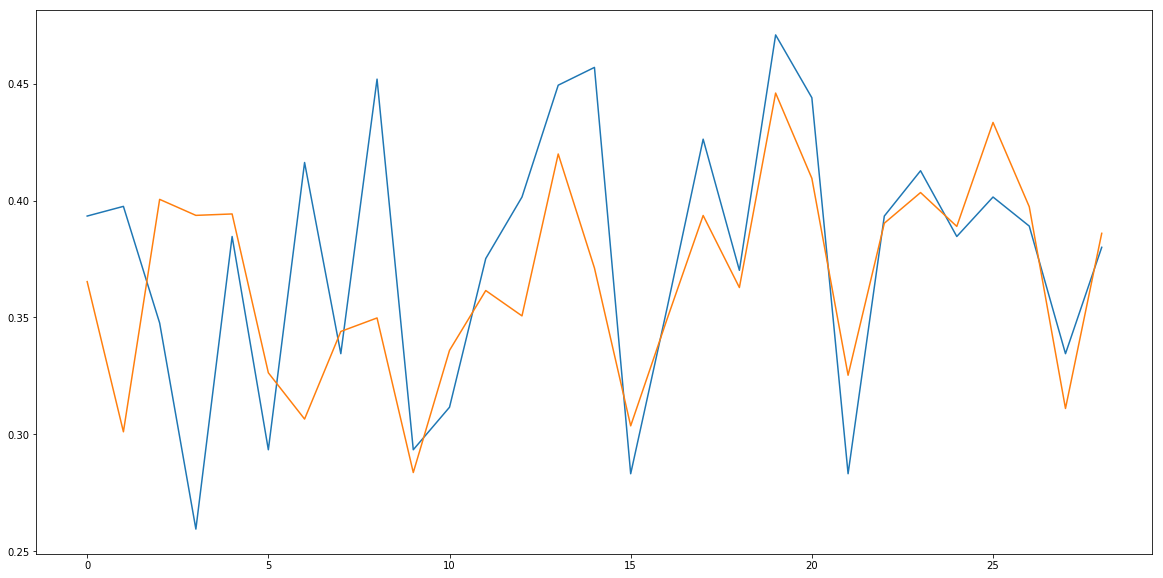

In [32]:
plt.figure(figsize=(20, 10))
plt.plot(y_valid.values)
plt.plot(pred_valid.flatten())

In [33]:
pred_trn = model.predict(map_train)
pred_trn_orig = utils.log_max_inv(pred_trn, max_log_y)

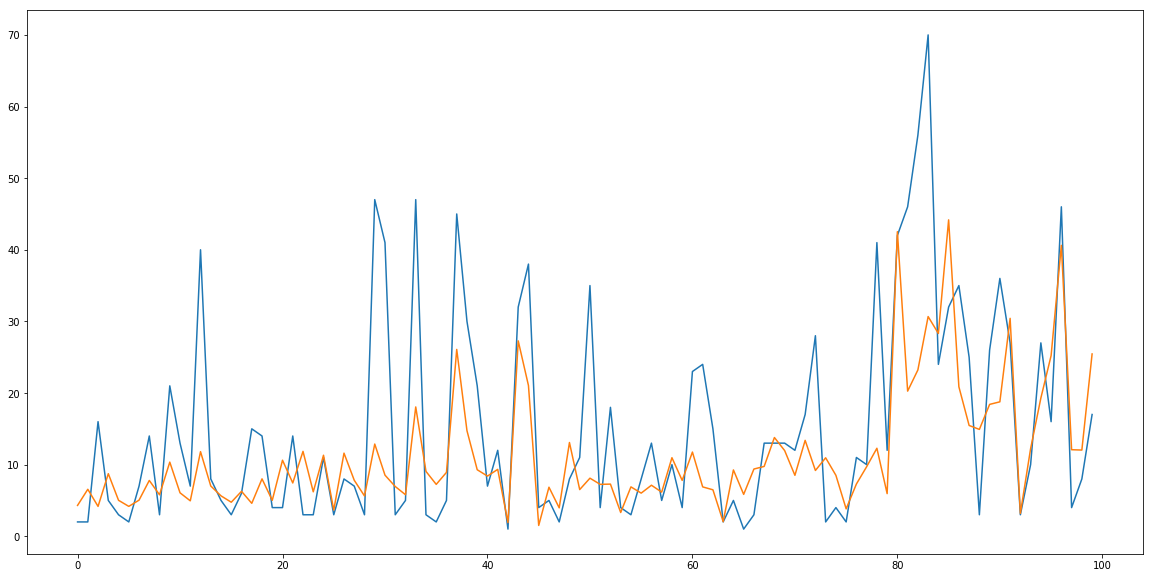

In [34]:
# edge s_p = 13100
s_p = 15200
win_len = 100

plt.figure(figsize=(20, 10))
plt.plot(y_train_orig[s_p:s_p+win_len])
plt.plot(pred_trn_orig[s_p:s_p+win_len].flatten())

In [39]:
map_train[11]

array([[-0.78972417, -0.79253807, -0.27968274, ..., -0.23305971,
         0.16854959,  0.07280731],
       [-0.78972417, -0.79253807, -0.27968274, ..., -0.23305971,
         0.16854959,  0.07280731],
       [-0.78972417, -0.79253807, -0.27968274, ..., -0.23305971,
         0.16854959,  0.07280731],
       ..., 
       [-0.78972417, -0.79253807, -0.27968274, ..., -0.74194521,
        -1.43548391, -1.44901045],
       [-0.78972417, -0.79253807, -0.27968274, ..., -0.74194521,
        -1.43548391, -1.44901045],
       [-0.78972417, -0.79253807, -0.27968274, ..., -0.74194521,
        -1.43548391, -1.44901045]])

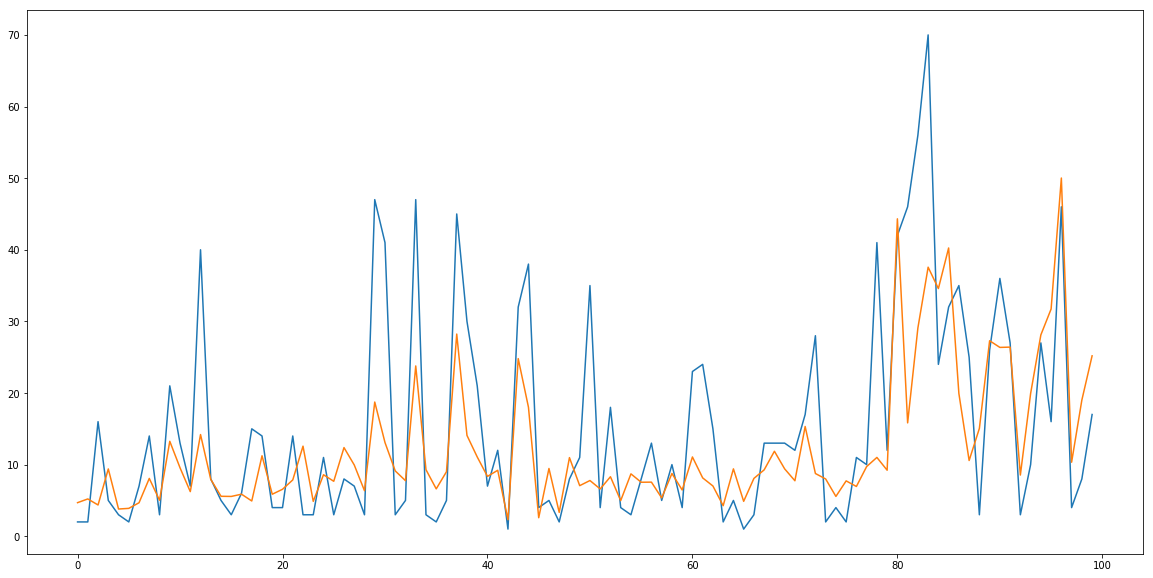

In [51]:

# edge s_p = 13100
s_p = 15200
win_len = 100

plt.figure(figsize=(20, 10))
plt.plot(y_train_orig[s_p:s_p+win_len])
plt.plot(pred_trn_orig[s_p:s_p+win_len].flatten())

(array([  2.51098000e+05,   9.31000000e+02,   3.30000000e+01,
          9.00000000e+00,   3.00000000e+00,   1.00000000e+00,
          0.00000000e+00,   2.00000000e+00,   1.00000000e+00,
          1.00000000e+00]),
 array([   1. ,   88.6,  176.2,  263.8,  351.4,  439. ,  526.6,  614.2,
         701.8,  789.4,  877. ]),
 <a list of 10 Patch objects>)

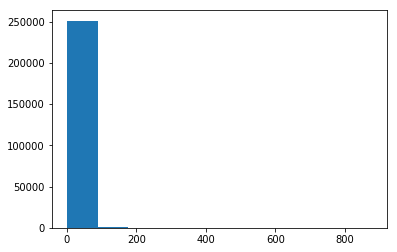

In [17]:
plt.hist(y_train_orig)

(array([  4.81100000e+03,   1.36420000e+04,   3.29410000e+04,
          6.41440000e+04,   7.52910000e+04,   5.37180000e+04,
          7.26700000e+03,   2.38000000e+02,   2.20000000e+01,
          5.00000000e+00]),
 array([ 0.  ,  0.08,  0.16,  0.24,  0.32,  0.4 ,  0.48,  0.56,  0.64,
         0.72,  0.8 ]),
 <a list of 10 Patch objects>)

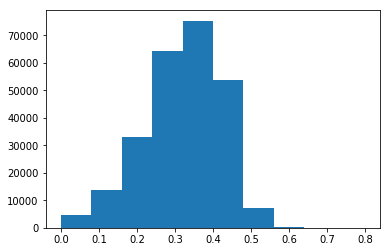

In [18]:
plt.hist(y_train)

(array([  1.73200000e+03,   1.83500000e+03,   4.14500000e+03,
          1.25570000e+04,   1.43593000e+05,   6.70450000e+04,
          1.77280000e+04,   3.21000000e+03,   2.08000000e+02,
          2.60000000e+01]),
 array([  7.62157072e-07,   6.63138991e-02,   1.32627036e-01,
          1.98940173e-01,   2.65253310e-01,   3.31566447e-01,
          3.97879584e-01,   4.64192720e-01,   5.30505857e-01,
          5.96818994e-01,   6.63132131e-01]),
 <a list of 10 Patch objects>)

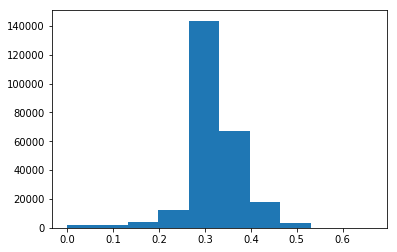

In [19]:
plt.hist(pred_trn)

# Submission

In [69]:
data_dir = r'./data'
test = pd.read_csv('{}/sample_submission.csv'.format(data_dir))
trn_like_test = utils.tes2trn(test)
trn_like_test = trn_like_test.assign(visitors = 0)
feas = utils.data2fea(trn_like_test, data_dir)
input_map = feas['x_map']
y = feas['y']

/home/ec2-user/ai/ml_utils/proj/RRVF/utils.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  store_info.drop_duplicates(inplace=True)
/usr/local/lib64/python3.6/site-packages/pandas/core/frame.py:3027: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)
/home/ec2-user/ai/ml_utils/proj/RRVF/utils.py:387: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  hpg_store_info.drop('src', axis=1, inplace=True, errors="ignore")
/usr/local/lib64/python3.6/s

In [70]:
pred_test = model.predict(input_map)
pred_test_orig = utils.log_max_inv(pred_test, max_log_y)
# pred_test_orig[pred_test_orig>1000] = pred_test_orig[pred_test_orig<1000].mean()

ValueError: Error when checking model : the list of Numpy arrays that you are passing to your model is not the size the model expected. Expected to see 13 array(s), but instead got the following list of 12 arrays: [array([[ 6],
       [ 6],
       [ 6],
       ..., 
       [12],
       [12],
       [12]]), array([[32],
       [32],
       [32],
       ..., 
       [64],
       [64],
       [64]]), array([[15],
...

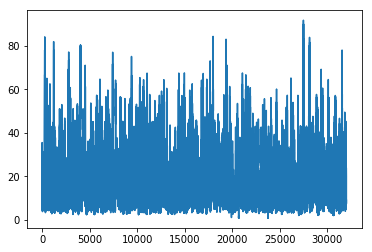

In [22]:
plt.plot(pred_test_orig)

In [23]:
test.visitors = pred_test_orig

In [24]:
test.to_csv('result/submission.csv', index=False)

# Explore results

In [52]:
data_dir = r'./data'
trn = pd.read_csv('{}/air_visit_data.csv'.format(data_dir))
feas = utils.data2fea(trn, data_dir)
input_map = feas['x_map']
y = feas['y']

/home/ec2-user/ai/ml_utils/proj/RRVF/utils.py:358: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  store_info.drop_duplicates(inplace=True)
/usr/local/lib64/python3.6/site-packages/pandas/core/frame.py:3027: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)
/home/ec2-user/ai/ml_utils/proj/RRVF/utils.py:369: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  hpg_store_info.drop('src', axis=1, inplace=True, errors="ignore")


In [53]:
pred_trn = model.predict(input_map)
pred_trn_orig = utils.log_max_inv(pred_trn, max_log_y)
trn = trn.assign(pred=pred_trn_orig)
trn = trn.assign(diff_val=np.abs(trn.pred - trn.visitors))
trn = trn.assign(diff_ratio=np.divide(trn.diff_val, trn.visitors))

In [82]:
DataFrameSummary(trn).summary()

,air_store_id,visit_date,visitors,visit_date_week,visit_date_dayofweek,visit_date_year,visit_date_month,pred,diff,diff_val,diff_ratio
count,NaN,NaN,252108,252108,252108,252108,252108,252108,252108,252108,252108
mean,NaN,NaN,20.9738,25.001,3.01968,2016.31,6.2082,19.4187,5.84301,5.84301,0.424395
std,NaN,NaN,16.757,16.0084,1.92399,0.461542,3.68026,13.8287,7.65068,7.65068,0.769973
min,NaN,NaN,1,1,0,2016,1,1,0,0,0
25%,NaN,NaN,9,10,1,2016,3,9.00508,1.69926,1.69926,0.118536
50%,NaN,NaN,17,26,3,2016,7,16.0588,3.86901,3.86901,0.252894
75%,NaN,NaN,29,39,5,2017,10,26.3859,7.63295,7.63295,0.449575
max,NaN,NaN,877,53,6,2017,12,206.999,859.973,859.973,32.3515
counts,252108,252108,252108,252108,252108,252108,252108,252108,252108,252108,252108
uniques,829,478,204,53,7,2,12,248368,249496,249496,251244


In [83]:
agg = trn.groupby('air_store_id').mean()

In [85]:
agg = agg.sort_values('diff_ratio')

In [88]:

DataFrameSummary(agg).summary()

,visitors,visit_date_week,visit_date_dayofweek,visit_date_year,visit_date_month,pred,diff,diff_val,diff_ratio
count,829,829,829,829,829,829,829,829,829
mean,21.2039,25.43,3.02443,2016.33,6.30872,19.6738,5.85496,5.85496,0.423868
std,11.775,3.32288,0.302565,0.120549,0.765667,11.6707,2.78625,2.78625,0.156497
min,1.1875,10.3667,2.03191,2016,2.83333,1.00132,0.188525,0.188525,0.0723492
25%,11.812,22.4159,2.91039,2016.24,5.60403,10.6193,3.90871,3.90871,0.311818
50%,19.1834,27.4475,3.02114,2016.37,6.77083,17.315,5.4273,5.4273,0.411022
75%,28.6452,27.7973,3.16239,2016.38,6.85659,26.9636,7.2956,7.2956,0.516158
max,115.471,36.1753,4.775,2017,8.78351,112.424,26.8287,26.8287,1.59998
counts,829,829,829,829,829,829,829,829,829
uniques,828,803,760,634,777,829,829,829,829


In [129]:
agg[ (agg.diff_ratio < 0.8) & (agg.diff_ratio > 0.6)].head()

,visitors,visit_date_week,visit_date_dayofweek,visit_date_year,visit_date_month,pred,diff,diff_val,diff_ratio
air_store_id,,,,,,,,,
air_bcce1ea4350b7b72,16.598592,27.665493,3.042254,2016.369718,6.841549,13.892851,6.700159,6.700159,0.601095
air_0164b9927d20bcc3,9.248322,25.335570,2.557047,2016.557047,6.268456,7.322750,4.034711,4.034711,0.601766
air_aed3a8b49abe4a48,9.080000,27.854545,3.061818,2016.360000,6.880000,7.566768,3.612044,3.612044,0.602255
air_ee3ba9af184c6c82,13.348684,31.750000,2.940789,2016.250000,7.776316,10.843468,5.682018,5.682018,0.602320
air_457efe8c3a30ea17,6.909326,22.238342,2.748705,2016.230570,5.577720,5.766316,3.036346,3.036346,0.602718


/usr/local/lib64/python3.6/site-packages/pandas/core/generic.py:3643: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


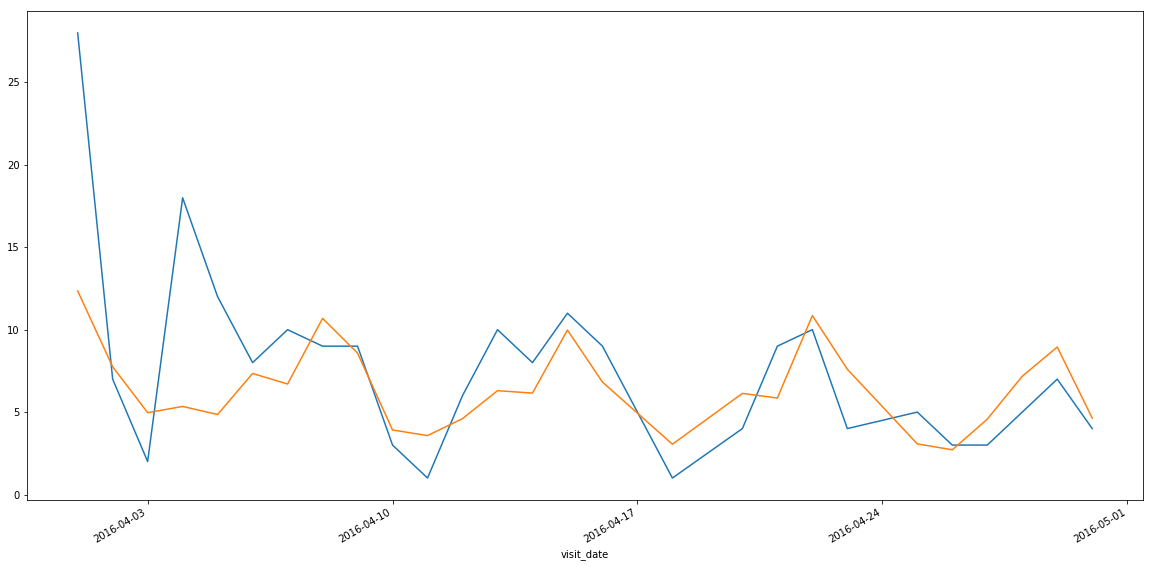

In [140]:
plt.figure(figsize=(20, 10))
a_store = trn[trn.air_store_id == "air_457efe8c3a30ea17"]
a_store.visit_date = pd.to_datetime(a_store.visit_date)
a_store = a_store.set_index('visit_date')
a_store['2016-04'].visitors.plot()
a_store['2016-04'].pred.plot()

# Worst cases

## 点少
- air_52a08ef3efdb4bb0

## 变化幅度大
- air_8e492076a1179383 变化幅度大 20 ~ 100
- air_4c2ed28f3f19ca52 变化幅度大
- air_df507aec929ce5f6
- air_9387ff95e886ebc7

20~50
 - air_22682e965418936f
 - air_3155ee23d92202da
 
Period change
 - air_93dd7070c9bf5453
 
非常奇怪：
air_9828505fefc77d75
 ## 好的
 30 ~ 60 change
 20 ~ 40

# Xgboost

In [11]:
import glob
import re
import pickle

import numpy as np
import pandas as pd
from isoweek import Week
from pandas_summary import DataFrameSummary
from keras.models import model_from_yaml
import utils
from keras.callbacks import TensorBoard, ModelCheckpoint
import xgboost
import random
import matplotlib.pyplot as plt, xgboost, operator, random, pickle


In [129]:
data_dir = r'./data'
trn = pd.read_csv('{}/air_visit_data.csv'.format(data_dir))
# trn = trn[trn.air_store_id.isin(trn.air_store_id.unique()[:1])]
trn = trn[trn.air_store_id.isin(['air_17a6ab40f97fd4d8'])]
feas = utils.data2fea(trn, data_dir)


/home/ec2-user/ai/ml_utils/proj/RRVF/utils.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  store_info.drop_duplicates(inplace=True)
/usr/local/lib64/python3.6/site-packages/pandas/core/frame.py:3027: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)
/home/ec2-user/ai/ml_utils/proj/RRVF/utils.py:387: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  hpg_store_info.drop('src', axis=1, inplace=True, errors="ignore")
/usr/local/lib64/python3.6/s

In [158]:
input_map = feas['x_map']
y = feas['y']
contin_cols = feas['contin_cols']
cat_map_fit = feas['cat_map_fit']
# valid & trn splitting
x_fit = feas['x_fit']
all_vars = feas['all_vars']
xgb_parms = {'learning_rate': 0.2, 'subsample': 0.95, 
         'colsample_bylevel': 0.6, 'silent': True, 'objective': 'reg:linear'}
trn_size = int(trn.shape[0]*0.9)
X_train, y_train_orig = x_fit[:trn_size], y[:trn_size]
X_valid, y_valid_orig = x_fit[trn_size:], y[trn_size:] 
y_train, y_valid, max_log_y = utils.uniform_y(y_train_orig, y_valid_orig)

xdata = xgboost.DMatrix(X_train, y_train, feature_names=all_vars)
xdata_val = xgboost.DMatrix(X_valid, y_valid, feature_names=all_vars)
xgb_parms['seed'] = random.randint(0,1e9)
model = xgboost.train(xgb_parms, xdata)

In [159]:
model.eval(xdata_val)

'[0]\teval-rmse:0.269828'

In [160]:
model.eval(xdata_val)


'[0]\teval-rmse:0.269828'

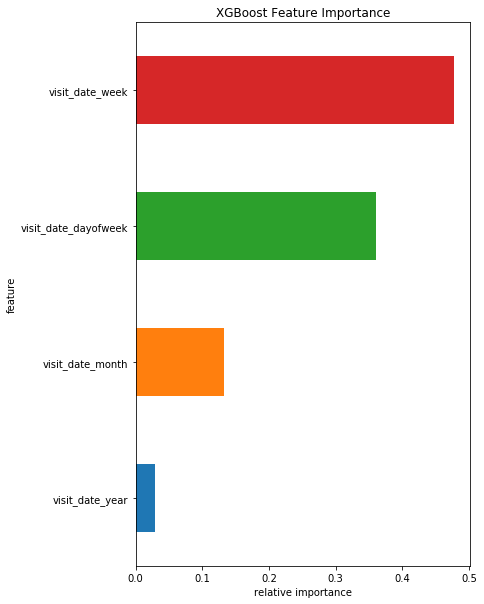

In [161]:
importance = model.get_fscore()
importance = sorted(importance.items(), key=operator.itemgetter(1))

df = pd.DataFrame(importance, columns=['feature', 'fscore'])
df['fscore'] = df['fscore'] / df['fscore'].sum()

df.plot(kind='barh', x='feature', y='fscore', legend=False, figsize=(6, 10))
plt.title('XGBoost Feature Importance')
plt.xlabel('relative importance');

In [162]:
pred_test = model.predict(xdata_val)
pred_test_orig = utils.log_max_inv(pred_test, max_log_y)

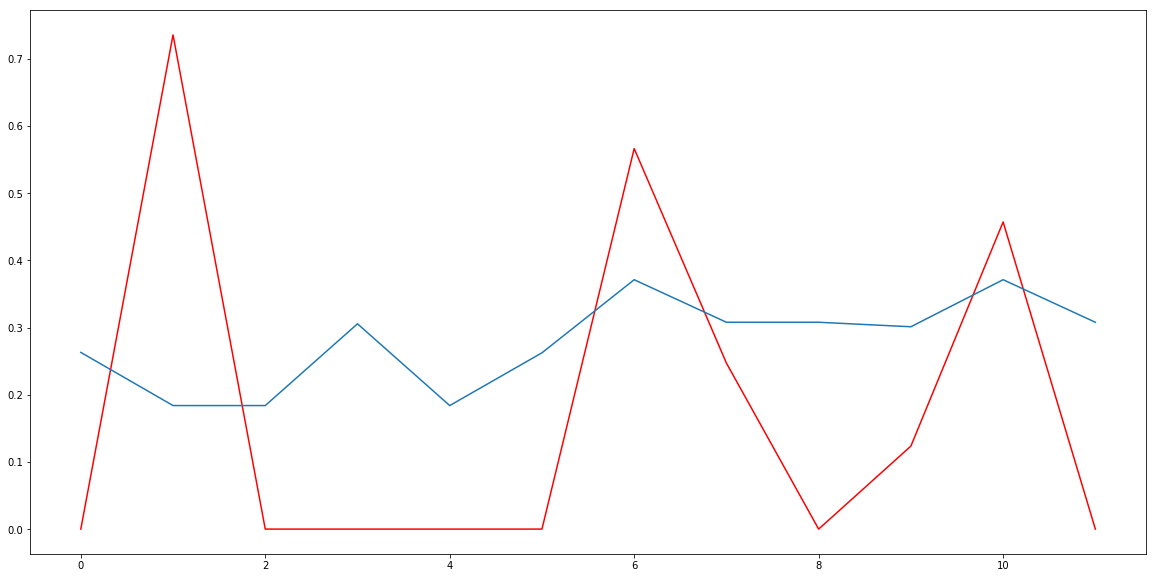

In [163]:
plt.figure(figsize=(20, 10))
plt.plot(y_valid.values, 'r')
plt.plot(pred_test.flatten())

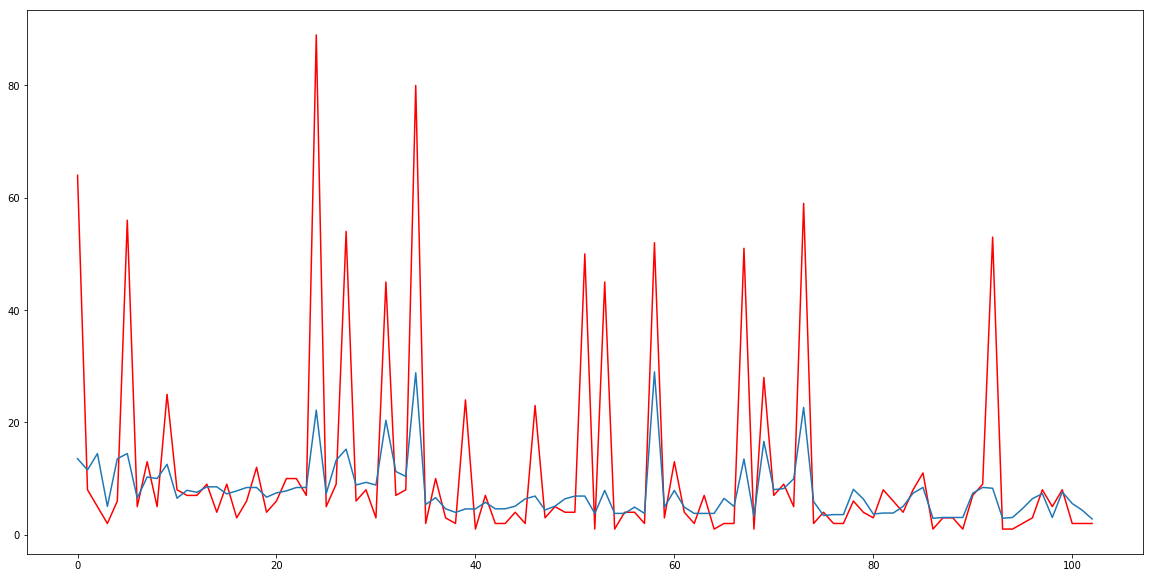

In [164]:
pred_trn = model.predict(xdata)
pred_trn_orig = utils.log_max_inv(pred_trn, max_log_y)
plt.figure(figsize=(20, 10))
plt.plot(y_train_orig.values, 'r')
plt.plot(pred_trn_orig.flatten())


In [143]:
trn.visit_date = pd.to_datetime(trn.visit_date)

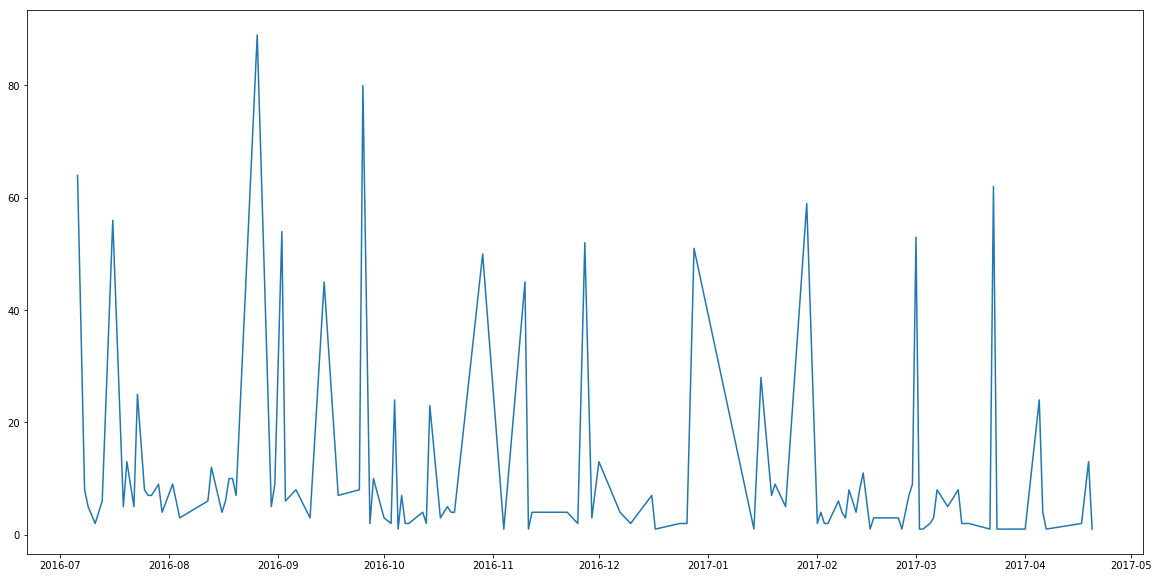

In [150]:
plt.figure(figsize=(20, 10))
plt.plot(trn.visit_date, trn.visitors)

In [64]:
import math
def rmsle(y_pred, targ):
    log_vars = np.log(targ + 1) - np.log(y_pred + 1)
    return math.sqrt(np.square(log_vars).mean())

rmsle(pred_test_orig, y_valid_orig)

0.6226534973185643

In [182]:
store_info = data['as']
area_cnt = store_info.groupby('air_area_name')['air_store_id'].count().reset_index().rename({'air_store_id': 'store_in_area'}, axis=1)

In [183]:
pd.merge(store_info, area_cnt, how="left")

,air_store_id,air_genre_name,air_area_name,air_latitude,air_longitude,store_in_area
0,air_0f0cdeee6c9bf3d7,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852,17
1,air_7cc17a324ae5c7dc,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852,17
2,air_fee8dcf4d619598e,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852,17
3,air_a17f0778617c76e2,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852,17
4,air_83db5aff8f50478e,Italian/French,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,51
5,air_99c3eae84130c1cb,Italian/French,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,51
6,air_f183a514cb8ff4fa,Italian/French,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,51
7,air_6b9fa44a9cf504a1,Italian/French,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,51
8,air_0919d54f0c9a24b8,Italian/French,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,51
9,air_2c6c79d597e48096,Italian/French,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,51


In [181]:
area_cnt

,air_area_name,store_in_area
0,Fukuoka-ken Fukuoka-shi Daimyō,64
1,Fukuoka-ken Fukuoka-shi Hakata Ekimae,16
2,Fukuoka-ken Fukuoka-shi Imaizumi,2
3,Fukuoka-ken Fukuoka-shi Momochi,6
4,Fukuoka-ken Fukuoka-shi Shiobaru,7
5,Fukuoka-ken Fukuoka-shi Takatori,2
6,Fukuoka-ken Fukuoka-shi Tenjin,2
7,Fukuoka-ken Fukuoka-shi Torikai,4
8,Fukuoka-ken Itoshima-shi Maebarunishi,7
9,Fukuoka-ken Kitakyūshū-shi Konyamachi,2
